### Simulation: Masternode Yield Farming

In [1]:
import os
import copy
import numpy as np
import time
import matplotlib.pyplot as plt
from IPython.display import Image
cwd =  os.getcwd().replace("notebooks/simulation","")
os.chdir(cwd)

from python.dev.helper import Helper

from python.dev.simulation import SimulationOrchestrator
from python.dev.simulation import EventQueue
from python.dev.simulation import EventExecutor

from python.dev.agent import TokenAgent
from python.dev.agent import LPTokenAgent
from python.dev.agent import UserAgent

from python.dev.action import MintAction
from python.dev.action import DepositAction
from python.dev.action import LPDepositChainAction
from python.dev.action import DepositChainAction
from python.dev.action import WithdrawChainAction
from python.dev.action import WithdrawAction
from python.dev.action import SwapAction
from python.dev.event import Mint
from python.dev.event import Deposit
from python.dev.event import Withdraw
from python.dev.event import Swap

from python.dev.math.model import TokenDeltaModel
from python.dev.math.model import TimeDeltaModel

from python.dev.lp import LiquidityPool
from python.dev.lp.event import LPEvent
from python.dev.lp.event import MintLPEvent
from python.dev.lp.event import DepositLPEvent
from python.dev.lp.event import SwapLPEvent

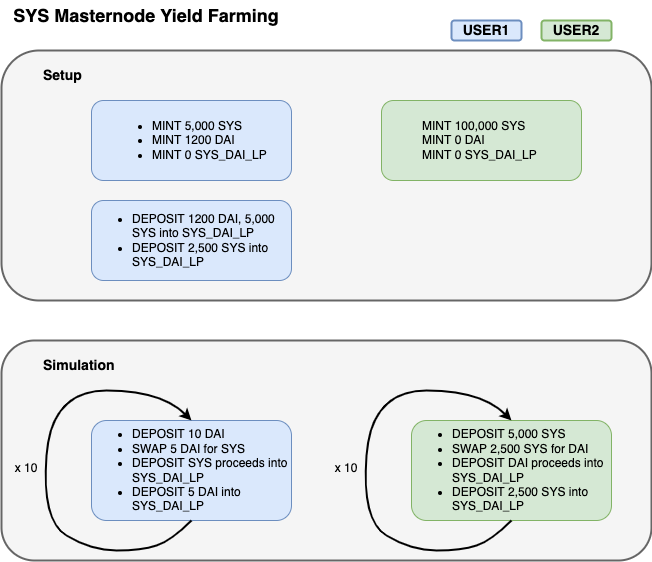

In [2]:
Image("images/jupyter/tutorials/masternode_nft.png", width = 600, height = 600)

### Initialize Agents

In [3]:
USER1 = UserAgent('USER1')
USER2 = UserAgent('USER2')

SYS = TokenAgent('SYS')
DAI = TokenAgent('DAI')

SYS_DAI_LP = LiquidityPool('SYS/DAI', USER1, SYS, DAI)
SYS_DAI = LPTokenAgent('SYS_DAI_LP', SYS_DAI_LP)

### Mint Tokens

In [4]:
apy = 0.1
t_delta = 109*24*3600

In [5]:
SYS_mint1 = Mint(5000, apy, True)
DAI_mint1 = Mint(5000, apy, True)
SYS_DAI_LP_mint1 = Mint(0, apy, True)

SYS_mint2 = Mint(100000, apy, True)
DAI_mint2 = Mint(0, apy, True)
SYS_DAI_LP_mint2 = Mint(0, apy, True)

In [6]:
m_action1 = MintAction(SYS_mint1, SYS, USER1)
m_action2 = MintAction(DAI_mint1, DAI, USER1)
m_action3 = MintAction(SYS_DAI_LP_mint1, SYS_DAI, USER1)

m_action4 = MintAction(SYS_mint2, SYS, USER2)
m_action5 = MintAction(DAI_mint2, DAI, USER2)
m_action6 = MintAction(SYS_DAI_LP_mint2, SYS_DAI, USER2)

### Setup Actions

In [7]:
sub_withdraw1 = Withdraw(apy, 2500, 0) 
sub_withdraw2 = Withdraw(apy, 2500, 0) 
w_action1 = WithdrawAction(sub_withdraw1, SYS, USER1, SYS_mint1.get_id())
w_action2 = WithdrawAction(sub_withdraw2, DAI, USER1, DAI_mint1.get_id())
d_action1 = LPDepositChainAction(w_action1, w_action2, SYS_DAI, USER1, SYS_DAI_LP_mint1.get_id())

### Batchset 1

In [8]:
deposit1 = Deposit(apy, 5000, t_delta) 
sub_withdraw1 = Withdraw(apy, 2500, 0)
sub_deposit1 = Deposit(apy, 2500, t_delta)
withdraw1 = Withdraw(apy, 2500, 0) 

In [9]:
# Deposit 5000 SYS
d_action2 = DepositAction(deposit1, SYS, USER2, SYS_mint2.get_id())

# Swap 2500 SYS for DAI
sub_w_action1 = WithdrawAction(sub_withdraw1, SYS, USER2, SYS_mint2.get_id())
sub_d_action1 = DepositAction(sub_deposit1, DAI, USER2, DAI_mint2.get_id())
s_action1 = SwapAction(sub_w_action1, sub_d_action1)

# Withdraw DAI proceeds and 2500 SYS
w_action3 = WithdrawChainAction(s_action1, DAI, USER2, DAI_mint2.get_id())
w_action4 = WithdrawAction(withdraw1, SYS, USER2, SYS_mint2.get_id())

# Deposit withdrawn DAI and SYS in LP
d_action3 = LPDepositChainAction(w_action3, w_action4, SYS_DAI, USER1, SYS_DAI_LP_mint2.get_id())

### Batchset 2

In [10]:
deposit2 = Deposit(apy, 50, t_delta) 
sub_withdraw2 = Withdraw(apy, 25, 0)
sub_deposit2 = Deposit(apy, 25, t_delta)
withdraw2 = Withdraw(apy, 25, 0) 

In [11]:
# Deposit 50 SYS
d_action4 = DepositAction(deposit2, SYS, USER1, SYS_mint1.get_id())

# Swap 2500 SYS for DAI
sub_w_action2 = WithdrawAction(sub_withdraw2, SYS, USER1, SYS_mint1.get_id())
sub_d_action2 = DepositAction(sub_deposit2, DAI, USER1, DAI_mint1.get_id())
s_action2 = SwapAction(sub_w_action2, sub_d_action2)

# Withdraw DAI proceeds and 2500 SYS
w_action5 = WithdrawChainAction(s_action2, DAI, USER1, DAI_mint1.get_id())
w_action6 = WithdrawAction(withdraw2, SYS, USER1, SYS_mint1.get_id())

# Deposit withdrawn DAI and SYS in LP
d_action5 = LPDepositChainAction(w_action5, w_action6, SYS_DAI, USER1, SYS_DAI_LP_mint1.get_id())

### Populate event queue

In [12]:
q = EventQueue()
q.add_event(m_action1)
q.add_event(m_action2)
q.add_event(m_action3)
q.add_event(m_action4)
q.add_event(m_action5)
q.add_event(m_action6)

# Setup
q.add_event(w_action1)
q.add_event(w_action2)
q.add_event(d_action1)

In [13]:
for k in range(10):
    
    # Batchset #1
    q.add_event(d_action2)    
    q.add_event(s_action1)
    q.add_event(w_action3)
    q.add_event(w_action4)
    q.add_event(d_action3)

    # Batchset #2
    q.add_event(d_action4)    
    q.add_event(s_action2)
    q.add_event(w_action5)
    q.add_event(w_action6)
    q.add_event(d_action5)

### Execute events

In [14]:
orchestrator = SimulationOrchestrator(verbose = True)
executor = EventExecutor(q, orchestrator)
executor.run()

======== Action Tasks ===========
# num_tasks: 109 

USER1 MINTs 5000.00 SYS 
USER1 MINTs 5000.00 DAI 
USER1 MINTs 0.00 SYS_DAI_LP 
USER2 MINTs 100000.00 SYS 
USER2 MINTs 0.00 DAI 
USER2 MINTs 0.00 SYS_DAI_LP 
[2022-08-16 18:13:02] USER1 WITHDRAWs 2500.00 SYS
[2022-08-16 18:13:02] USER1 WITHDRAWs 2500.00 DAI
[2022-08-16 18:13:02] USER1 DEPOSITs 2500.00 SYS_DAI_LP from SYS and DAI proceeds
[2022-12-03 17:13:02] USER2 DEPOSITs 5000.00 SYS
[2022-12-03 17:13:02] USER2 SWAPs 2500.00 SYS for DAI
[2022-12-03 17:13:02] USER2 WITHDRAWs 2500.00 from DAI proceeds
[2022-12-03 17:13:02] USER2 WITHDRAWs 2500.00 SYS
[2022-12-03 17:13:02] USER1 DEPOSITs 2500.00 SYS_DAI_LP from DAI and SYS proceeds
[2022-12-03 17:13:02] USER1 DEPOSITs 50.00 SYS
[2022-12-03 17:13:02] USER1 SWAPs 25.00 SYS for DAI
[2022-12-03 17:13:02] USER1 WITHDRAWs 25.00 from DAI proceeds
[2022-12-03 17:13:02] USER1 WITHDRAWs 25.00 SYS
[2022-12-03 17:13:02] USER1 DEPOSITs 25.00 SYS_DAI_LP from DAI and SYS proceeds
[2023-03-22 18:13:02

### Analyze

In [15]:
tSYS = SYS.get_token()
tDAI = DAI.get_token()
tSYS_DAI = SYS_DAI.get_token()

SYS_addr1 = SYS.get_address(SYS_mint1.get_id())
DAI_addr1 = DAI.get_address(DAI_mint1.get_id())
SYS_DAI_addr1 = SYS_DAI.get_address(SYS_DAI_LP_mint1.get_id())

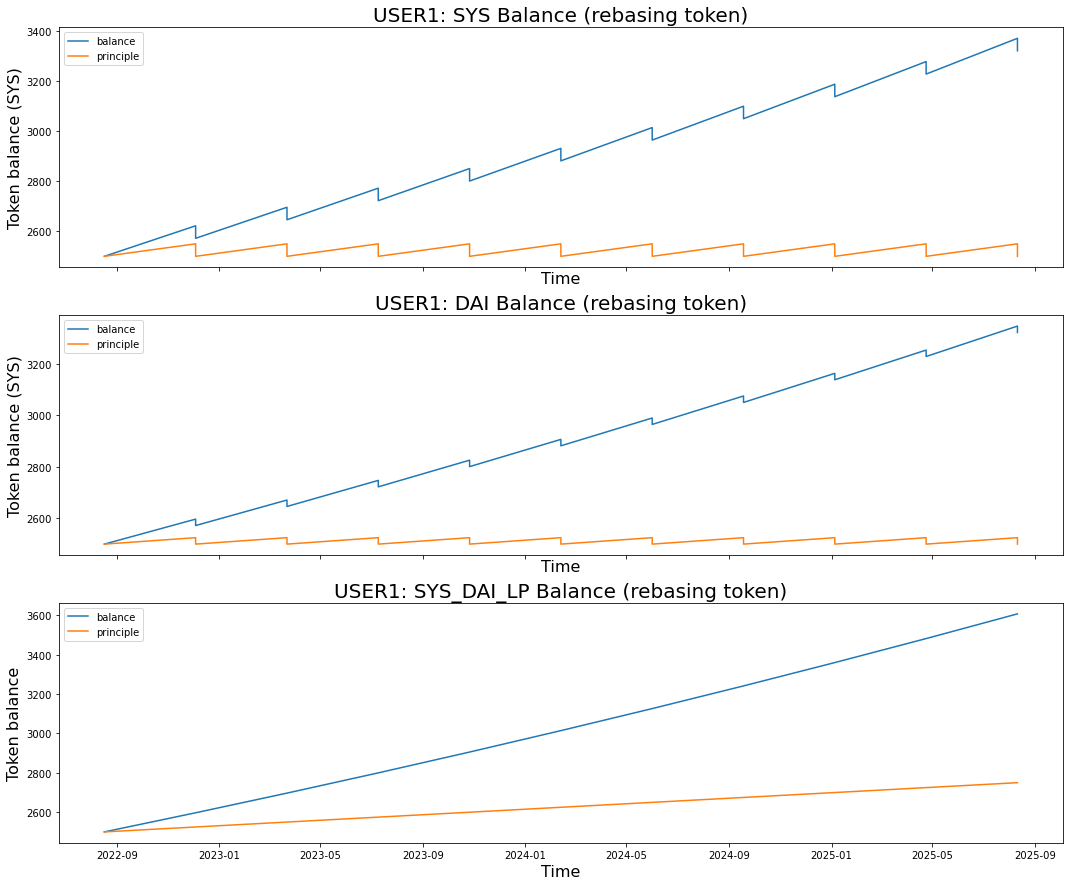

In [16]:
SYS_states1 = tSYS.get_state_series(SYS_addr1)
principle = SYS_states1.get_principle() 
balance = SYS_states1.get_balance() 
tSamp = SYS_states1.get_tstamp()  

fig, (SYS_ax, DAI_ax, SYS_DAI_ax) = plt.subplots(nrows=3, sharex=True, sharey=False, figsize=(18, 15))

SYS_ax.plot(tSamp[1:], balance[1:], label='balance') 
SYS_ax.plot(tSamp[1:], principle[1:], label='principle') 
SYS_ax.set_title("USER1: SYS Balance (rebasing token)", fontsize=20)
SYS_ax.set_ylabel("Token balance (SYS)", fontsize=16)
SYS_ax.set_xlabel('Time', fontsize=16)
SYS_ax.legend()

DAI_states1 = tDAI.get_state_series(DAI_addr1)
principle = DAI_states1.get_principle() 
balance = DAI_states1.get_balance() 
tSamp = DAI_states1.get_tstamp() 

DAI_ax.plot(tSamp[1:], balance[1:], label='balance') 
DAI_ax.plot(tSamp[1:], principle[1:], label='principle') 
DAI_ax.set_title("USER1: DAI Balance (rebasing token)", fontsize=20)
DAI_ax.set_ylabel("Token balance (SYS)", fontsize=16)
DAI_ax.set_xlabel('Time', fontsize=16)
DAI_ax.legend()

SYS_DAI_states1 = tSYS_DAI.get_state_series(SYS_DAI_addr1)
principle = SYS_DAI_states1.get_principle() 
balance = SYS_DAI_states1.get_balance() 
tSamp = SYS_DAI_states1.get_tstamp() 

SYS_DAI_ax.plot(tSamp[1:], balance[1:], label='balance') 
SYS_DAI_ax.plot(tSamp[1:], principle[1:], label='principle') 
SYS_DAI_ax.set_title("USER1: SYS_DAI_LP Balance (rebasing token)", fontsize=20)
SYS_DAI_ax.set_ylabel("Token balance", fontsize=16)
SYS_DAI_ax.set_xlabel('Time', fontsize=16)
SYS_DAI_ax.legend()

In [17]:
SYS_addr2 = SYS.get_address(SYS_mint2.get_id())
DAI_addr2 = DAI.get_address(DAI_mint2.get_id())
SYS_DAI_addr2 = SYS_DAI.get_address(SYS_DAI_LP_mint2.get_id())

In [18]:
SYS_DAI_states2 = tSYS_DAI.get_state_series(SYS_DAI_addr2)
principle = SYS_DAI_states2.get_principle() 
balance = SYS_DAI_states2.get_balance() 
tSamp = SYS_DAI_states2.get_tstamp() 

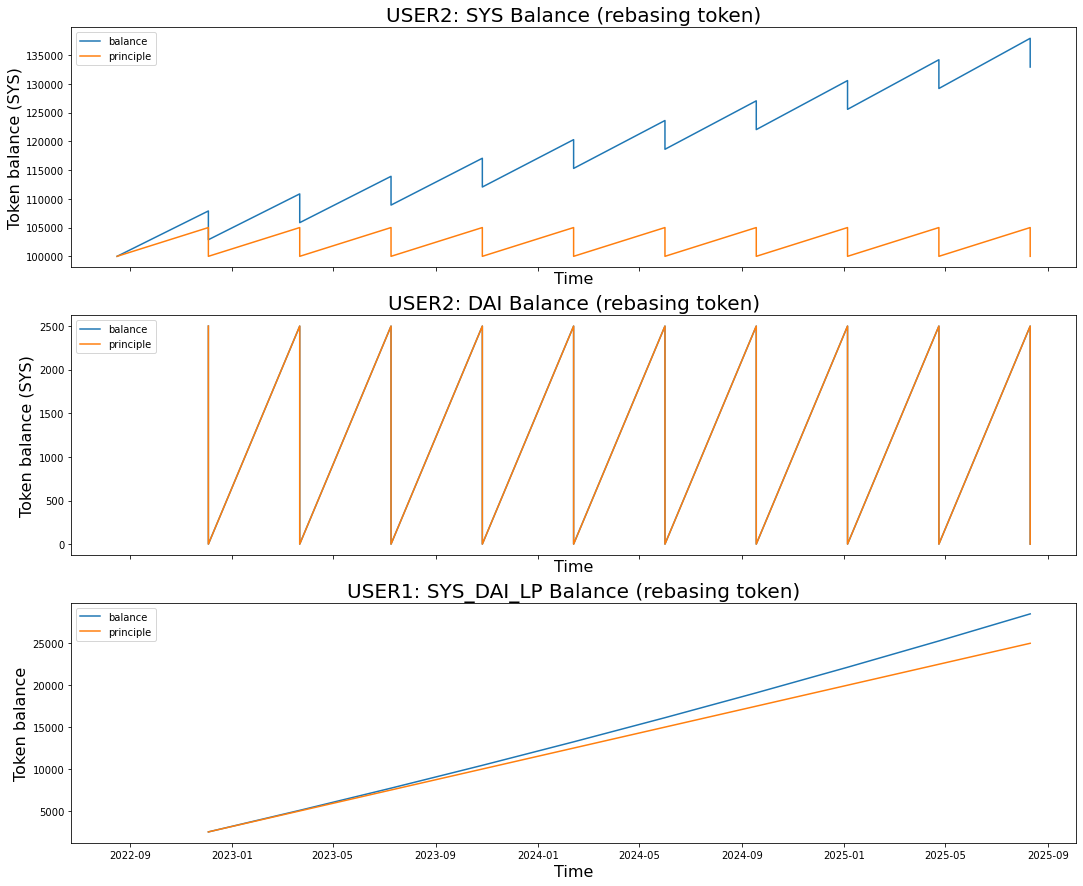

In [19]:
# Analyze Token balances

SYS_states2 = tSYS.get_state_series(SYS_addr2)
principle = SYS_states2.get_principle() 
balance = SYS_states2.get_balance() 
tSamp = SYS_states2.get_tstamp()  

fig, (SYS_ax, DAI_ax, SYS_DAI_ax) = plt.subplots(nrows=3, sharex=True, sharey=False, figsize=(18, 15))

SYS_ax.plot(tSamp, balance, label='balance') 
SYS_ax.plot(tSamp, principle, label='principle') 
SYS_ax.set_title("USER2: SYS Balance (rebasing token)", fontsize=20)
SYS_ax.set_ylabel("Token balance (SYS)", fontsize=16)
SYS_ax.set_xlabel('Time', fontsize=16)
SYS_ax.legend()

DAI_states2 = tDAI.get_state_series(DAI_addr2)
principle = DAI_states2.get_principle() 
balance = DAI_states2.get_balance() 
tSamp = DAI_states2.get_tstamp() 

DAI_ax.plot(tSamp[1:], balance[1:], label='balance') 
DAI_ax.plot(tSamp[1:], principle[1:], label='principle') 
DAI_ax.set_title("USER2: DAI Balance (rebasing token)", fontsize=20)
DAI_ax.set_ylabel("Token balance (SYS)", fontsize=16)
DAI_ax.set_xlabel('Time', fontsize=16)
DAI_ax.legend()

SYS_DAI_states2 = tSYS_DAI.get_state_series(SYS_DAI_addr2)
principle = SYS_DAI_states2.get_principle() 
balance = SYS_DAI_states2.get_balance() 
tSamp = SYS_DAI_states2.get_tstamp() 

SYS_DAI_ax.plot(tSamp[1:], balance[1:], label='balance') 
SYS_DAI_ax.plot(tSamp[1:], principle[1:], label='principle') 
SYS_DAI_ax.set_title("USER1: SYS_DAI_LP Balance (rebasing token)", fontsize=20)
SYS_DAI_ax.set_ylabel("Token balance", fontsize=16)
SYS_DAI_ax.set_xlabel('Time', fontsize=16)
SYS_DAI_ax.legend()

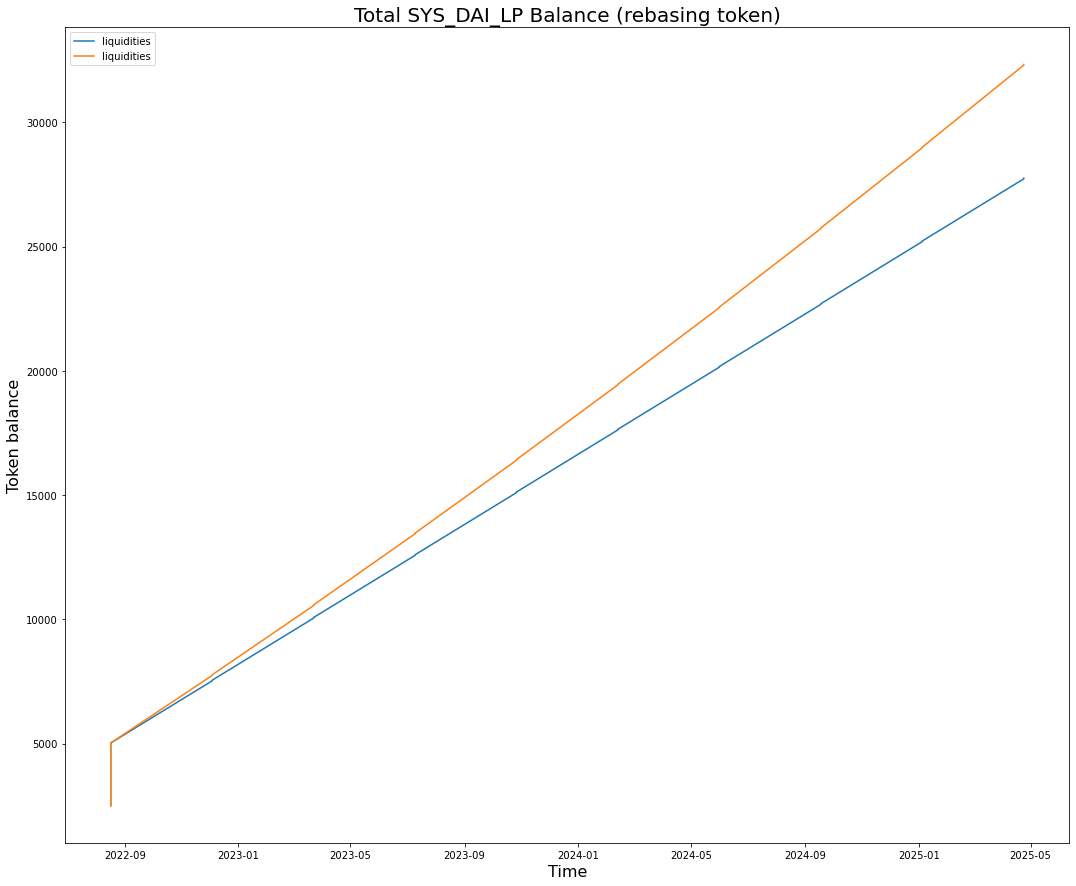

In [20]:
tSamp = SYS_DAI_LP.get_lp_events().get_dates()
utSamp = SYS_DAI_LP.get_lp_events().get_unix_time_stamps()
prices = SYS_DAI_LP.get_lp_events().get_prices()
liquidities = SYS_DAI_LP.get_lp_events().get_liquidity_values()
balances = SYS_DAI_LP.get_lp_events().gen_yield_balances(apy)

fig, (liq_ax) = plt.subplots(nrows=1, sharex=True, sharey=False, figsize=(18, 15))

liq_ax.plot(tSamp, liquidities, label='liquidities') 
liq_ax.plot(tSamp, balances, label='liquidities') 
liq_ax.set_title("Total SYS_DAI_LP Balance (rebasing token)", fontsize=20)
liq_ax.set_ylabel("Token balance", fontsize=16)
liq_ax.set_xlabel('Time', fontsize=16)
liq_ax.legend()